## GMM vs EDM 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from os.path import join
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid, save_image
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")
from train_edm import edm_sampler, EDM, create_model
from core.edm_utils import get_default_config, create_edm

In [4]:
# set pandas display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### CIFAR10 EDM training process vs GMM scores

#### Early phase ckpt stats

In [4]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2317/checkpoints"
df_syn = pd.read_csv(join(ckptdir, "..", "edm_50k_epoch_gmm_exp_var.csv"))

In [7]:
df_syn.sigma.unique()

array([1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01, 7.5e-01,
       1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 3.0e+01,
       4.0e+01, 8.0e+01])

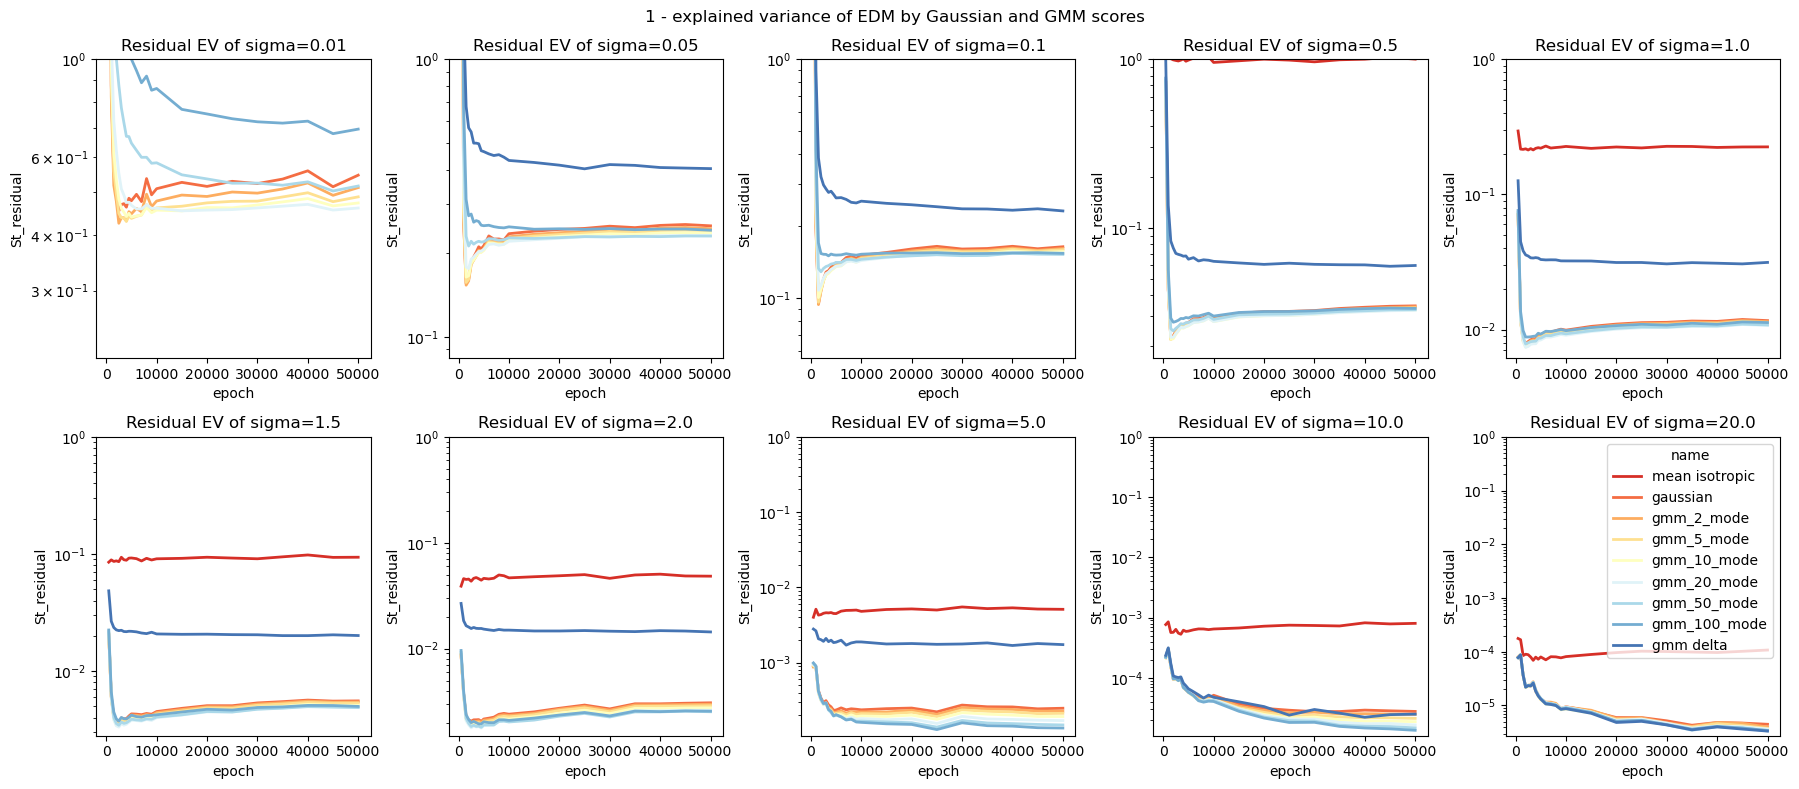

In [27]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn[(df_syn.sigma == sigma) & (df_syn.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", "gmm_2_mode", "gmm_5_mode", 
                       "gmm_10_mode", "gmm_20_mode", "gmm_50_mode", "gmm_100_mode", "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM score by Gaussian and GMM scores (CIFAR10 initial training)")
plt.tight_layout()
plt.show()

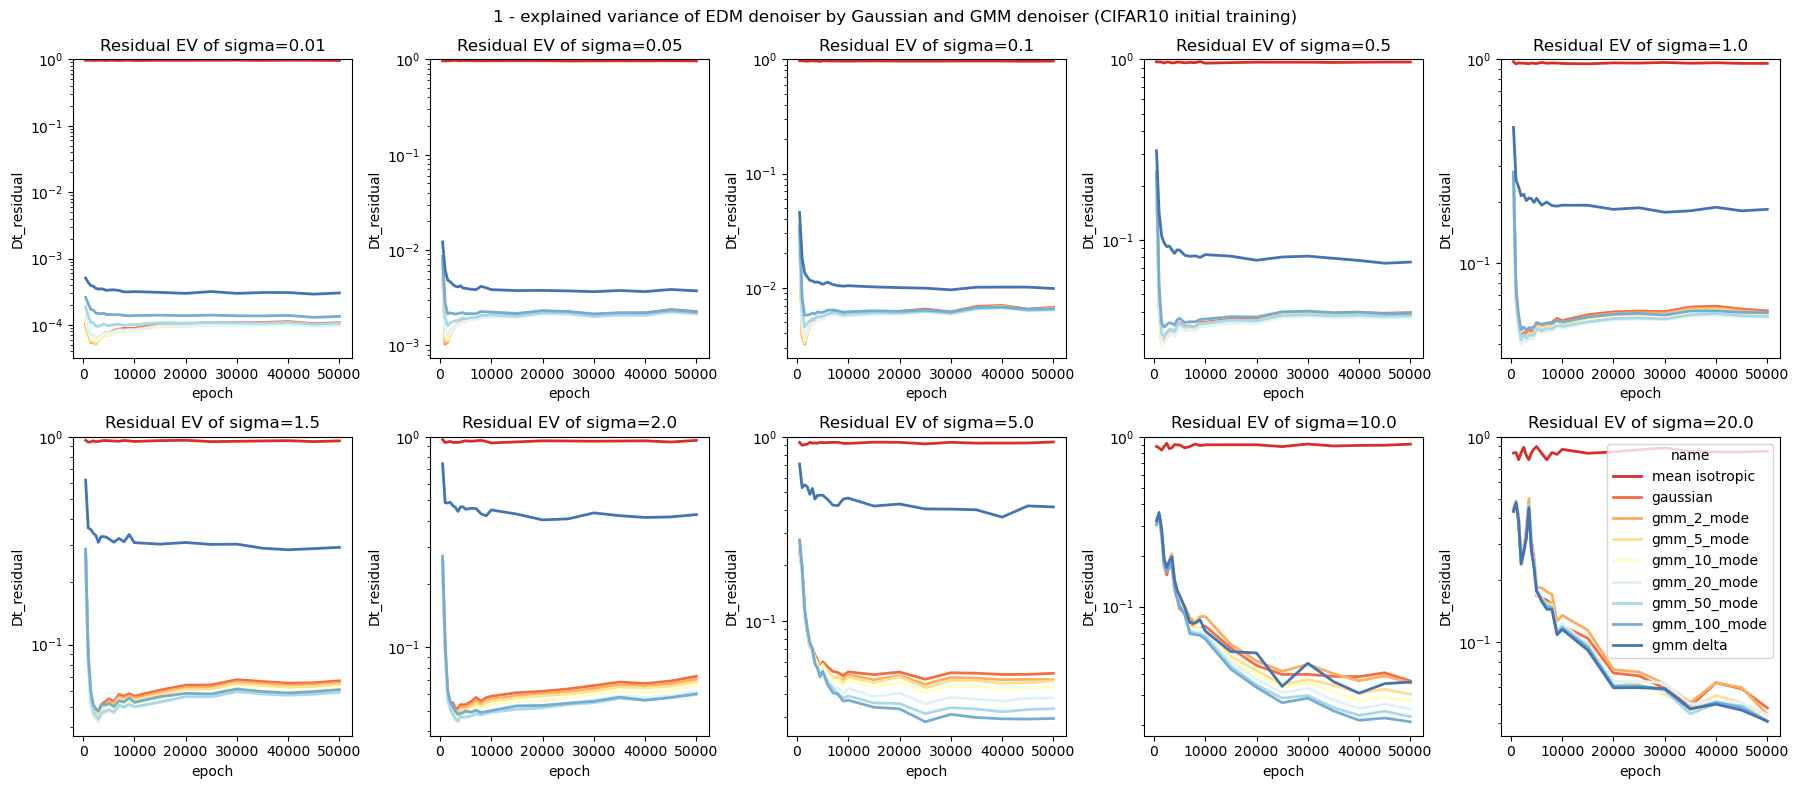

In [44]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn[(df_syn.sigma == sigma) & (df_syn.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="Dt_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", "gmm_2_mode", "gmm_5_mode", 
                       "gmm_10_mode", "gmm_20_mode", "gmm_50_mode", "gmm_100_mode", "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM denoiser by Gaussian and GMM denoiser (CIFAR10 initial training)")
plt.tight_layout()
plt.show()

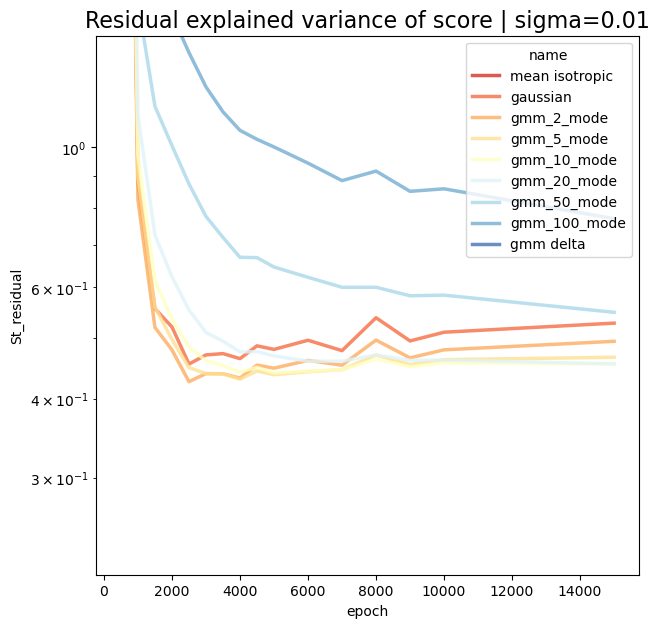

In [49]:
sigma = 0.01
plt.figure(figsize=(7, 7))
sns.lineplot(data=df_syn[(df_syn.sigma == sigma) & (df_syn.epoch > 0) & (df_syn.epoch < 2E4)], 
            x="epoch", y="St_residual", palette="RdYlBu", hue="name", lw=2.5, alpha=0.8,
            hue_order=["mean isotropic", "gaussian", "gmm_2_mode", "gmm_5_mode", 
                       "gmm_10_mode", "gmm_20_mode", "gmm_50_mode", "gmm_100_mode", "gmm delta"])
# TODO: add the shaded errorbar from `St_EV_std`
plt.yscale("log")
plt.ylim(None, 1.5)
plt.title(f"Residual explained variance of score | sigma={sigma}", fontsize=16)
plt.show()

#### Late phase ckpt CIFAR10

In [21]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_cifar10_20240130-2318/checkpoints"
df_syn_lt = pd.read_csv(join(ckptdir, "..", "edm_365k_epoch_gmm_exp_var.csv"))

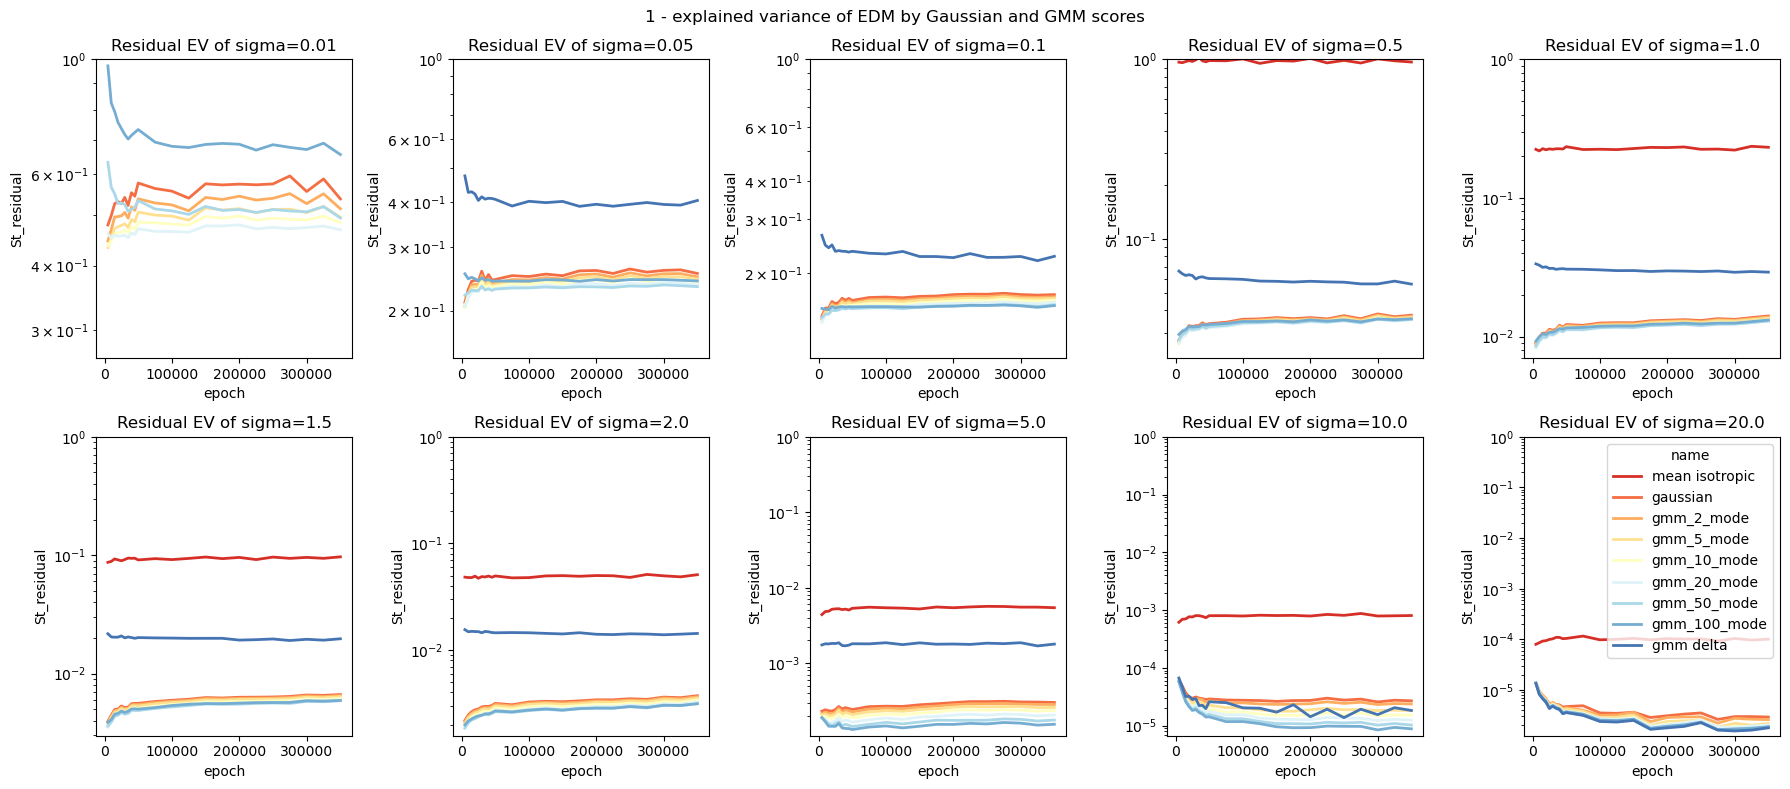

In [26]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_lt[(df_syn_lt.sigma == sigma) & (df_syn_lt.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", "gmm_2_mode", "gmm_5_mode", 
                       "gmm_10_mode", "gmm_20_mode", "gmm_50_mode", "gmm_100_mode", "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM by Gaussian and GMM scores (late training)")
plt.tight_layout()
plt.show()

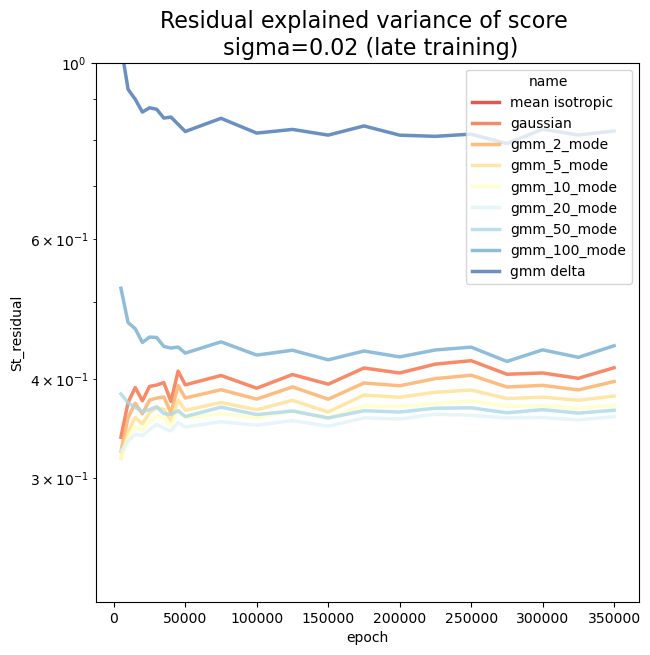

In [32]:
sigma = 0.02
plt.figure(figsize=(7, 7))
sns.lineplot(data=df_syn_lt[(df_syn_lt.sigma == sigma) & (df_syn_lt.epoch > 0)], 
            x="epoch", y="St_residual", palette="RdYlBu", hue="name", lw=2.5, alpha=0.8,
            hue_order=["mean isotropic", "gaussian", "gmm_2_mode", "gmm_5_mode", 
                       "gmm_10_mode", "gmm_20_mode", "gmm_50_mode", "gmm_100_mode", "gmm delta"])
# TODO: add the shaded errorbar from `St_EV_std`
plt.yscale("log")
plt.ylim(None, 1.0)
plt.title(f"Residual explained variance of score \n sigma={sigma} (late training)", fontsize=16)
plt.show()

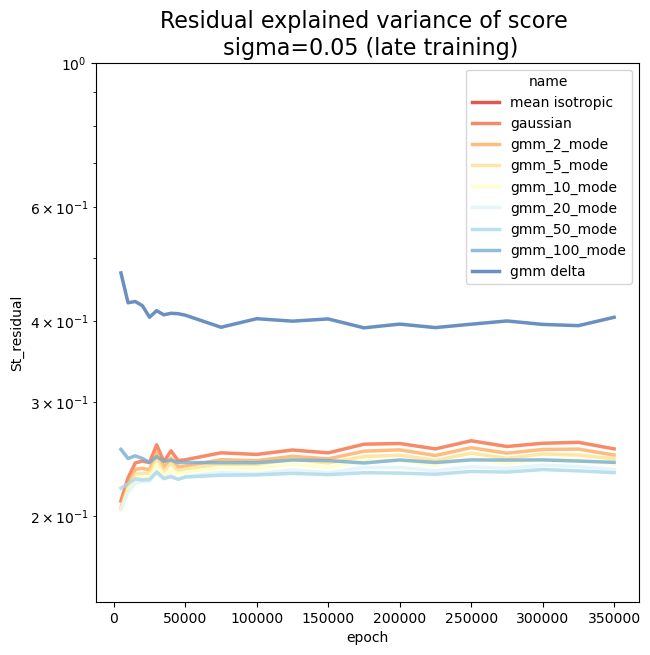

In [33]:
sigma = 0.05
plt.figure(figsize=(7, 7))
sns.lineplot(data=df_syn_lt[(df_syn_lt.sigma == sigma) & (df_syn_lt.epoch > 0)], 
            x="epoch", y="St_residual", palette="RdYlBu", hue="name", lw=2.5, alpha=0.8,
            hue_order=["mean isotropic", "gaussian", "gmm_2_mode", "gmm_5_mode", 
                       "gmm_10_mode", "gmm_20_mode", "gmm_50_mode", "gmm_100_mode", "gmm delta"])
# TODO: add the shaded errorbar from `St_EV_std`
plt.yscale("log")
plt.ylim(None, 1.0)
plt.title(f"Residual explained variance of score \n sigma={sigma} (late training)", fontsize=16)
plt.show()

### MNIST EDM training process vs GMM scores

#### Early Phase MNIST

In [34]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240130-2207/checkpoints/"
df_syn_mnst = pd.read_csv(join(ckptdir, "..", "MNIST_edm_25k_epoch_gmm_exp_var.csv"))

In [35]:
df_syn_mnst.name.unique()

array(['EDM', 'mean isotropic', 'mean + std isotropic', 'gaussian',
       'gaussian regularize', 'gmm_2_mode', 'gmm_5_mode', 'gmm_10_mode',
       'gmm_20_mode', 'gmm_50_mode', 'gmm_100_mode', 'gmm_200_mode',
       'gmm_500_mode', 'gmm delta'], dtype=object)

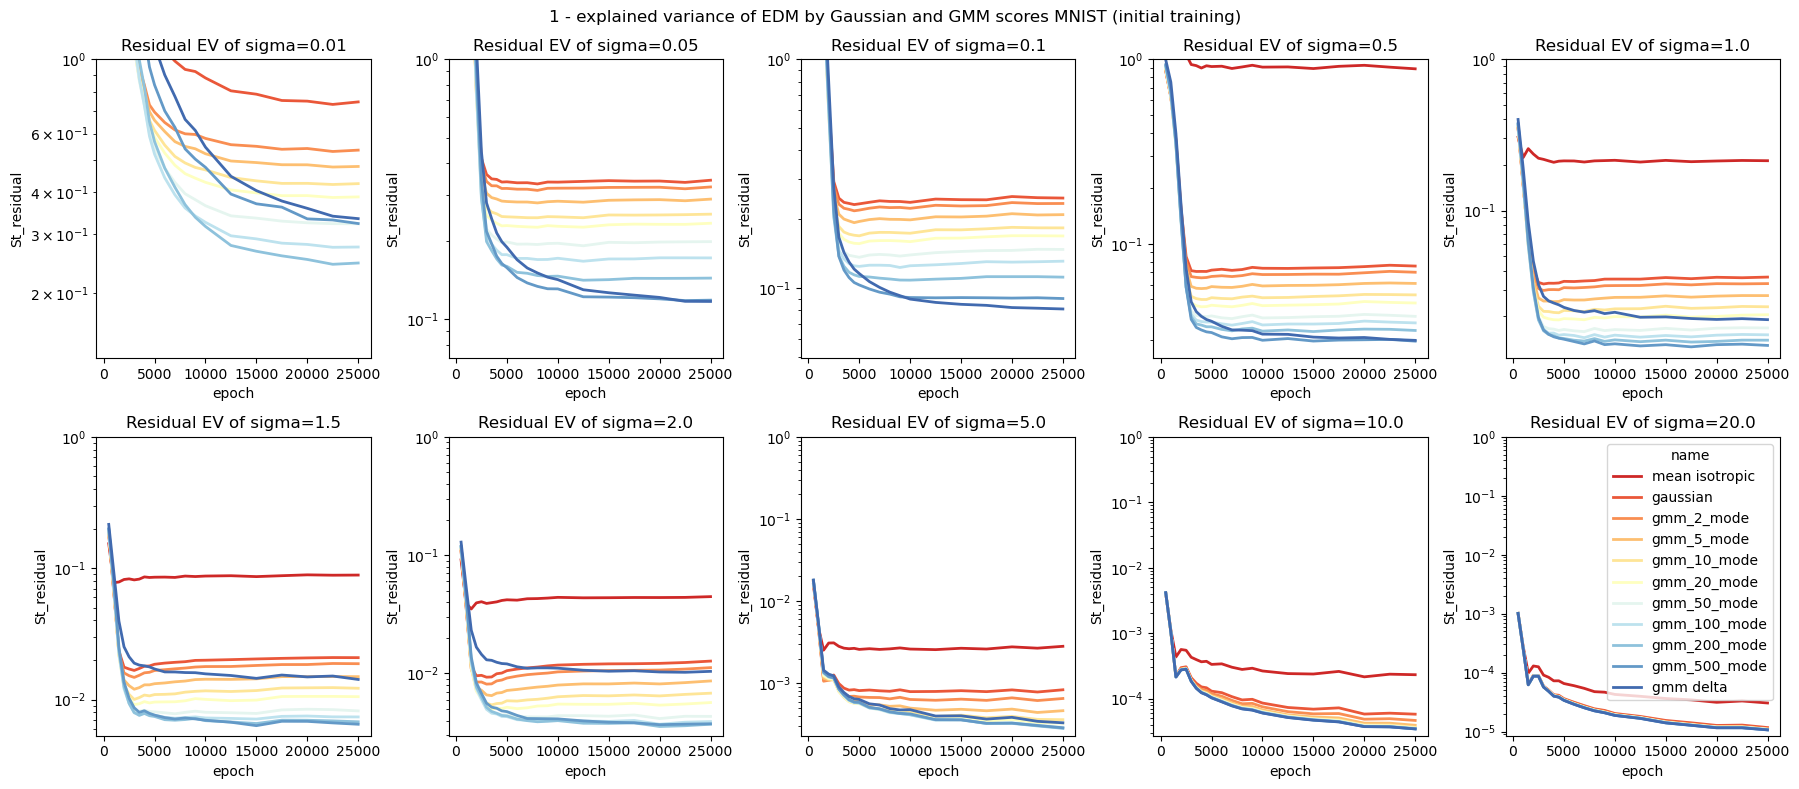

In [39]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_mnst[(df_syn_mnst.sigma == sigma) & (df_syn_mnst.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", 'gmm_2_mode', 
                'gmm_5_mode', 'gmm_10_mode', 'gmm_20_mode', 'gmm_50_mode', 
                'gmm_100_mode', 'gmm_200_mode','gmm_500_mode', "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM by Gaussian and GMM scores MNIST (initial training)")
plt.tight_layout()
plt.show()

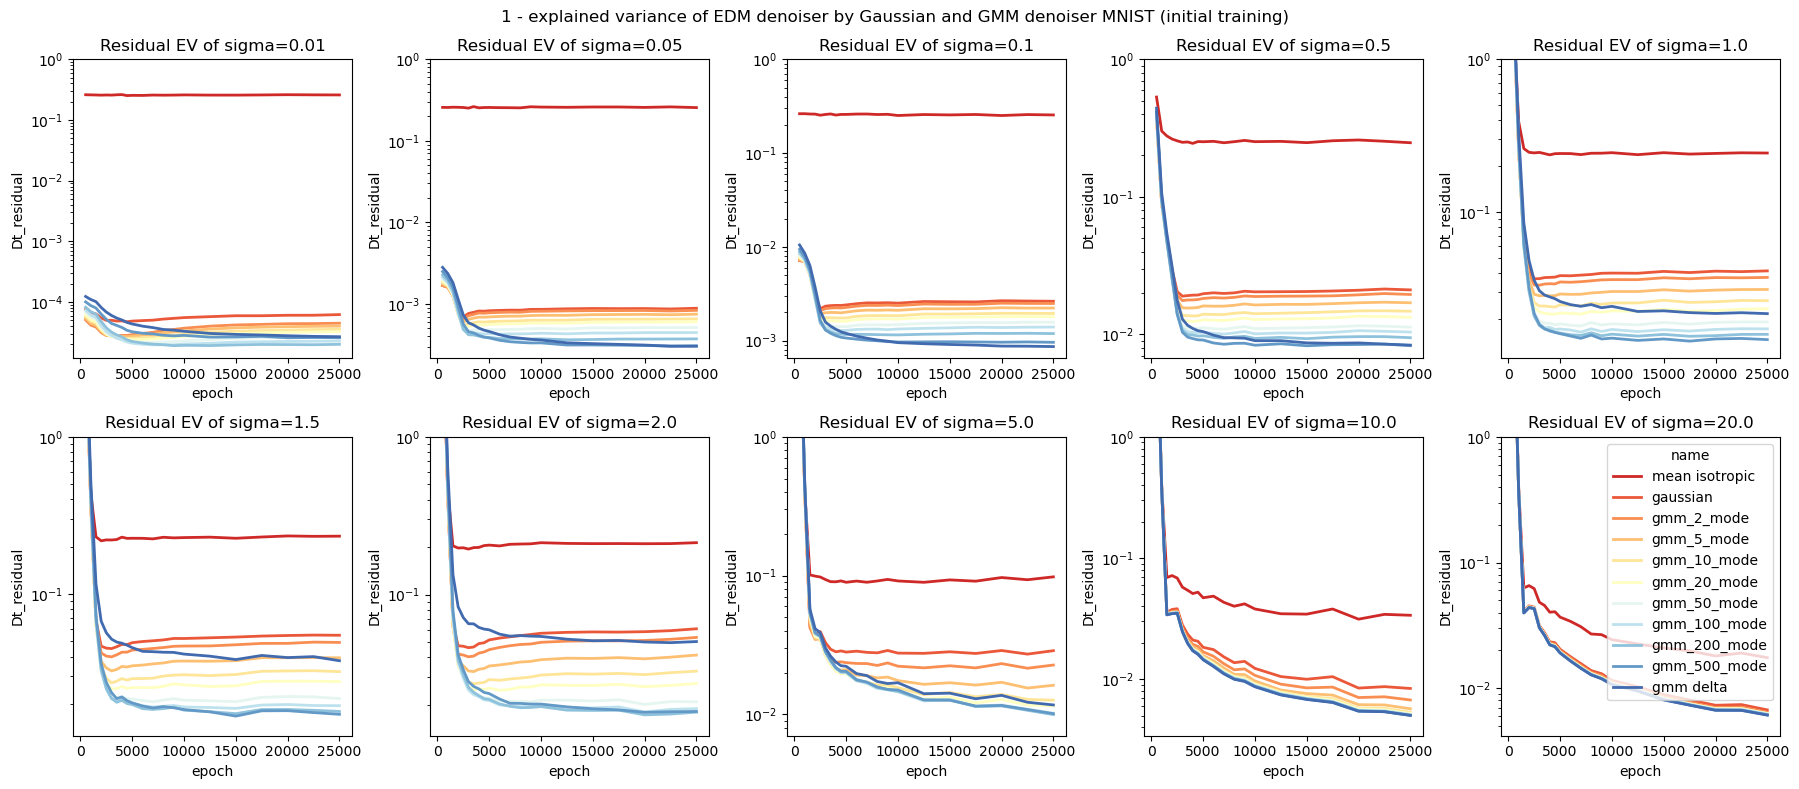

In [43]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_mnst[(df_syn_mnst.sigma == sigma) & (df_syn_mnst.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="Dt_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", 'gmm_2_mode', 
                'gmm_5_mode', 'gmm_10_mode', 'gmm_20_mode', 'gmm_50_mode', 
                'gmm_100_mode', 'gmm_200_mode','gmm_500_mode', "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM denoiser by Gaussian and GMM denoiser MNIST (initial training)")
plt.tight_layout()
plt.show()

#### Late Phase MNIST

In [37]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342/checkpoints/"
df_syn_mnst_lt = pd.read_csv(join(ckptdir, "..", "MNIST_edm_1000k_epoch_gmm_exp_var.csv"))

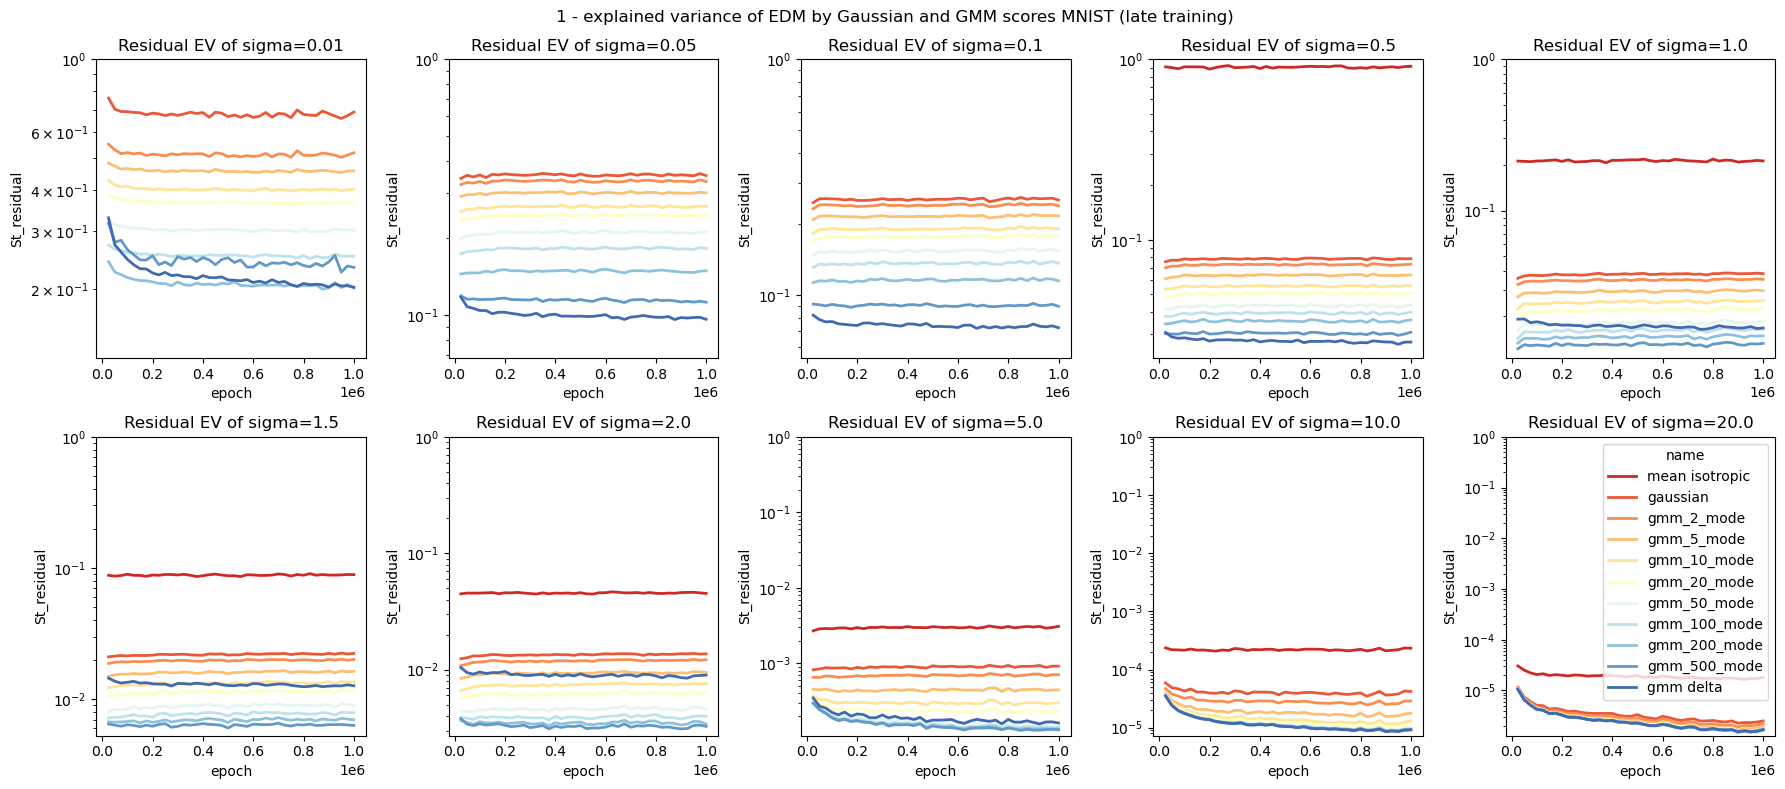

In [38]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_mnst_lt[(df_syn_mnst_lt.sigma == sigma) & (df_syn_mnst_lt.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", 'gmm_2_mode', 
                'gmm_5_mode', 'gmm_10_mode', 'gmm_20_mode', 'gmm_50_mode', 
                'gmm_100_mode', 'gmm_200_mode','gmm_500_mode', "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM by Gaussian and GMM scores MNIST (late training)")
plt.tight_layout()
plt.show()

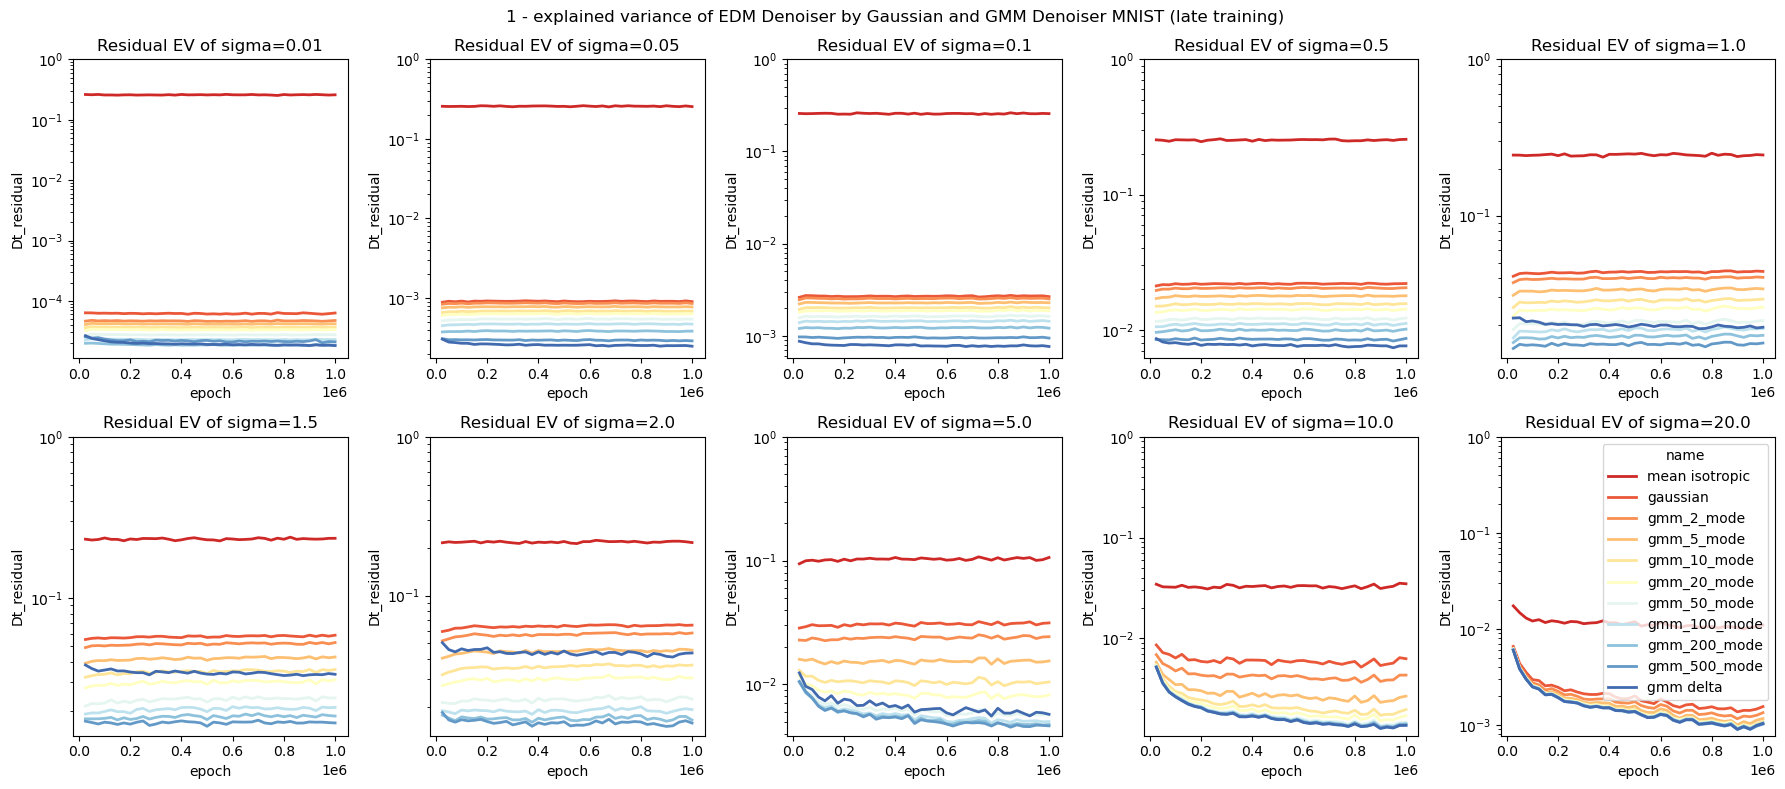

In [41]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_mnst_lt[(df_syn_mnst_lt.sigma == sigma) & (df_syn_mnst_lt.epoch > 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="Dt_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", 'gmm_2_mode', 
                'gmm_5_mode', 'gmm_10_mode', 'gmm_20_mode', 'gmm_50_mode', 
                'gmm_100_mode', 'gmm_200_mode','gmm_500_mode', "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM Denoiser by Gaussian and GMM Denoiser MNIST (late training)")
plt.tight_layout()
plt.show()

### MNIST score with varying rank and components

In [50]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342/checkpoints/"
df_gmm_rk = pd.read_csv(join(ckptdir, "..", "MNIST_edm_1000k_epoch_gmm_exp_var_gmm_rk.csv"))

In [ ]:
df_gmm_rk["St_residual"] = 1 - df_gmm_rk["St_EV"]
df_gmm_rk["Dt_residual"] = 1 - df_gmm_rk["Dt_EV"]
df_gmm_rk[['n_cluster', 'n_rank']] = df_gmm_rk['name'].str.extract(r'gmm_(\d+)_mode_(\d+)_rank')
df_gmm_rk['n_cluster'] = df_gmm_rk['n_cluster'].astype(float)
df_gmm_rk['n_rank'] = df_gmm_rk['n_rank'].astype(float)

In [55]:
df_gmm_rk.columns

Index(['Unnamed: 0', 'epoch', 'sigma', 'name', 'St_EV', 'St_EV_std', 'St_EV_rev', 'St_EV_rev_std', 'Dt_EV', 'Dt_EV_std', 'Dt_EV_rev', 'Dt_EV_rev_std', 'St_Var', 'St_Var_std', 'Dt_Var', 'Dt_Var_std', 'n_cluster', 'n_rank'], dtype='object')

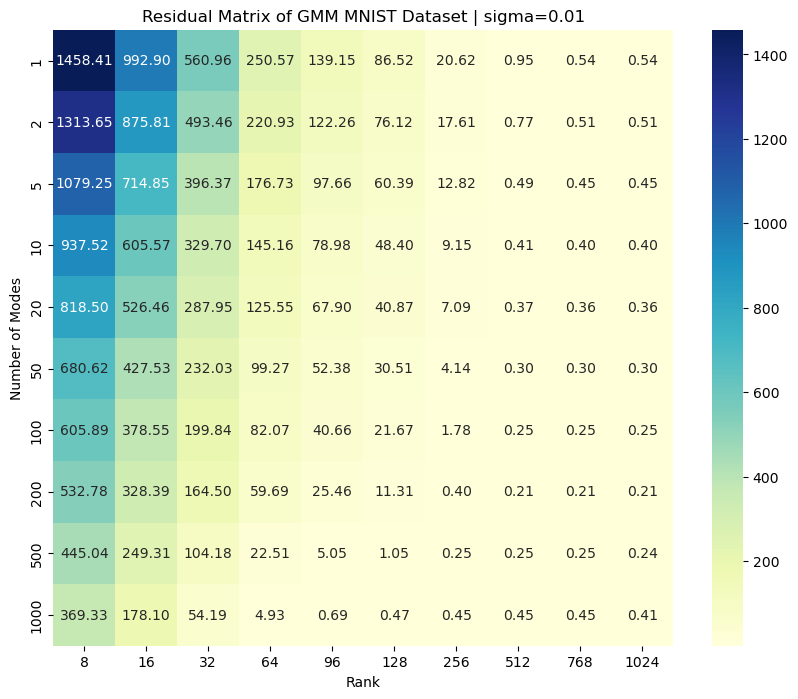

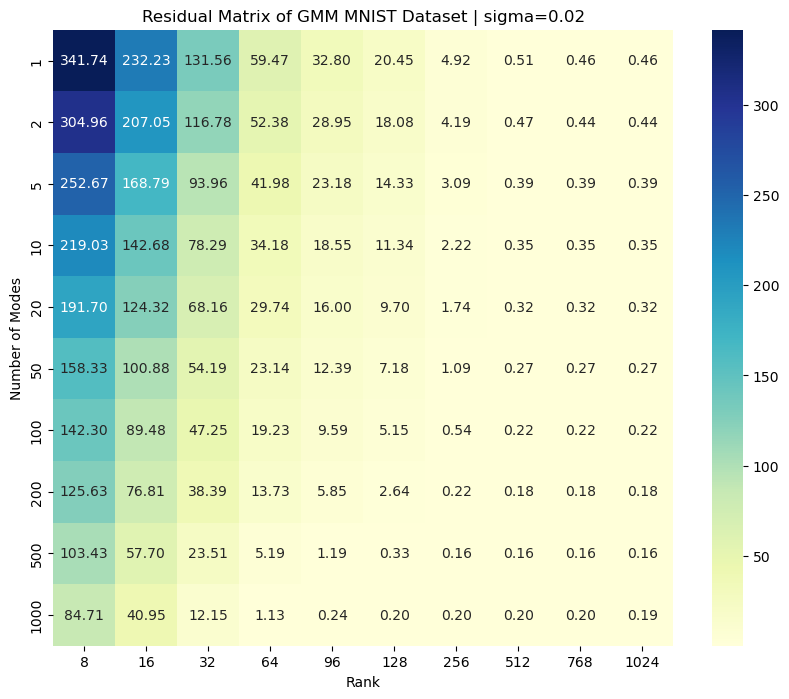

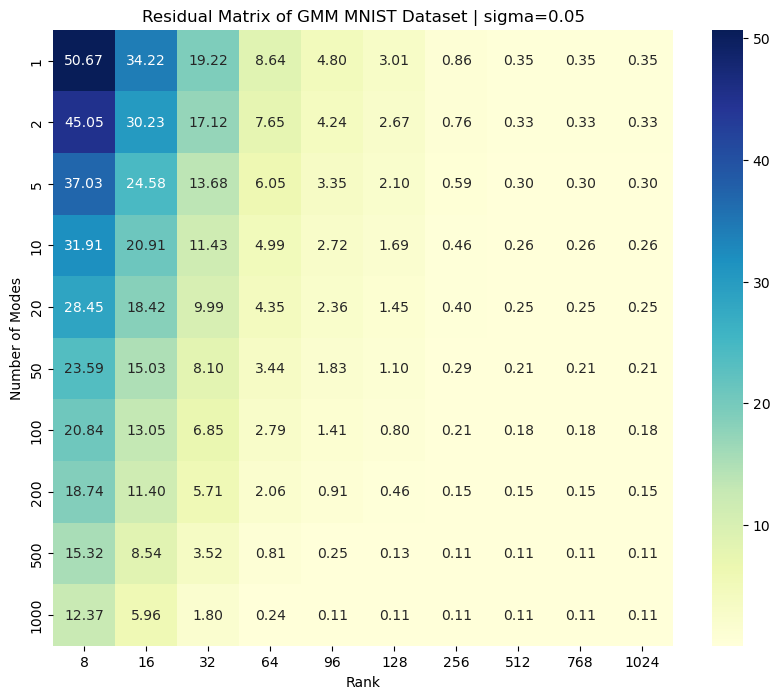

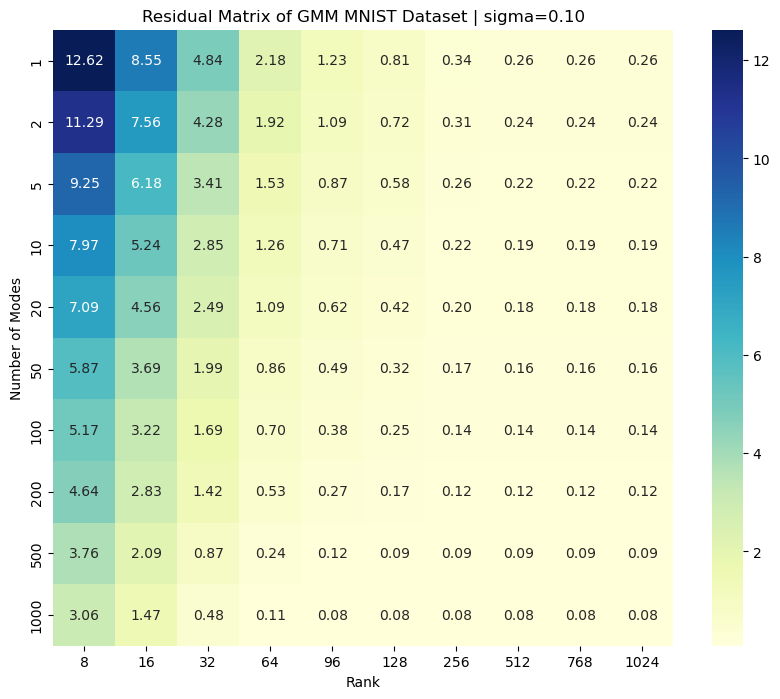

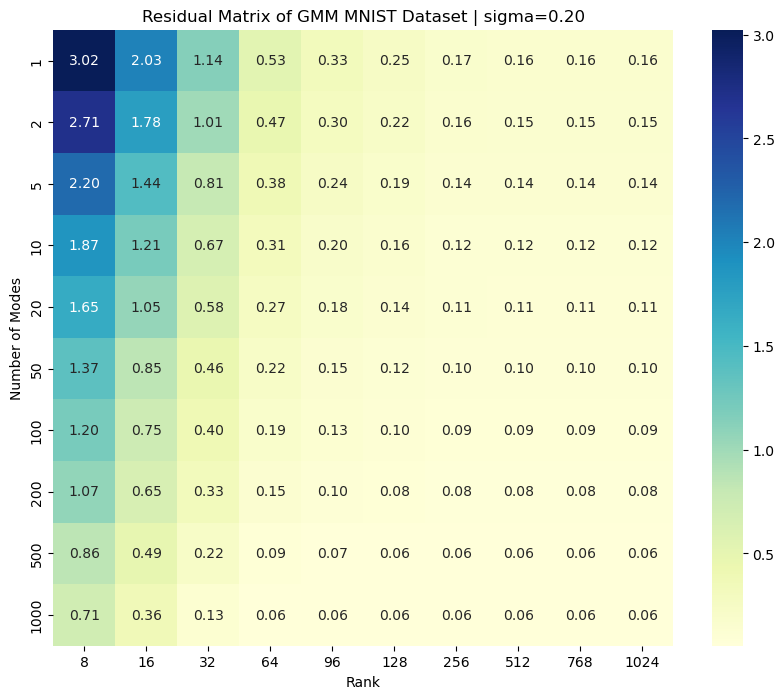

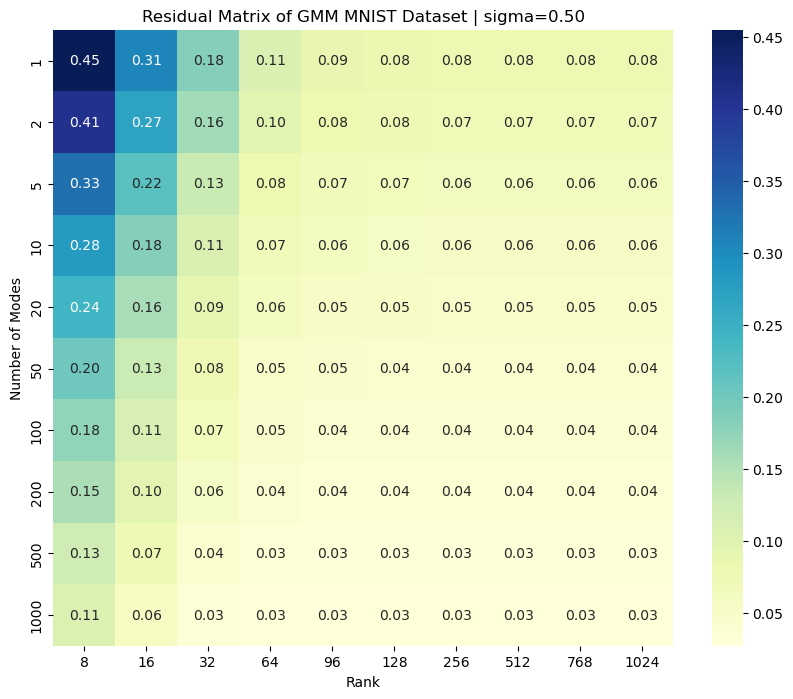

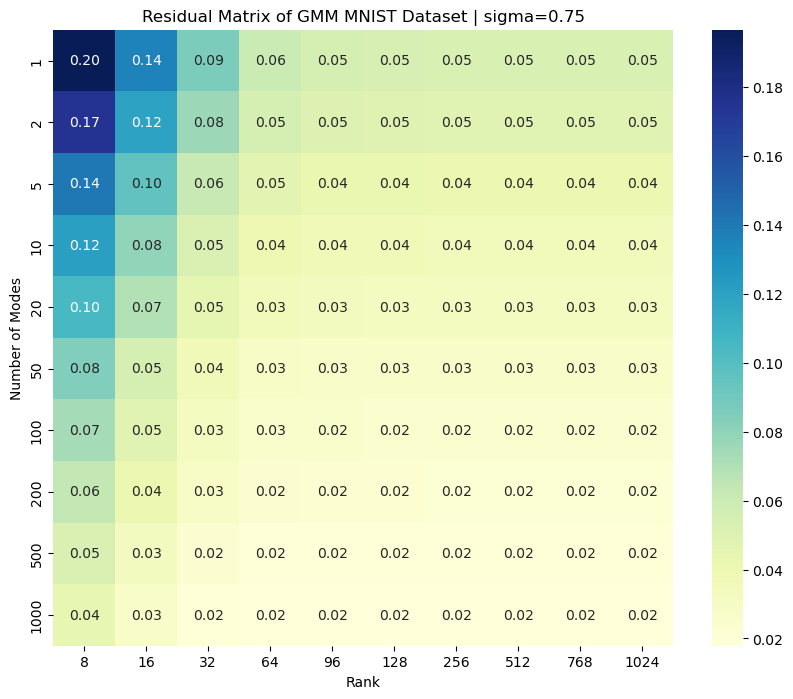

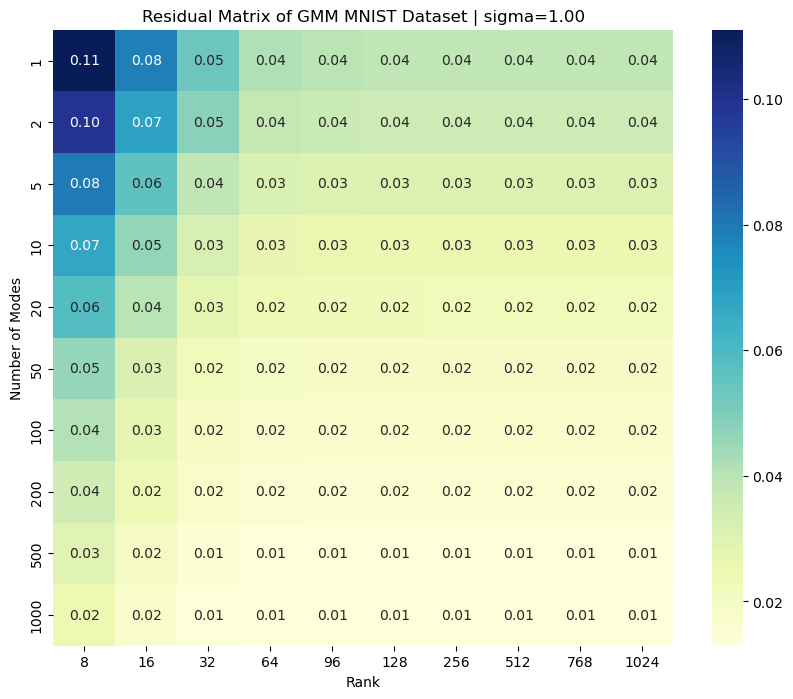

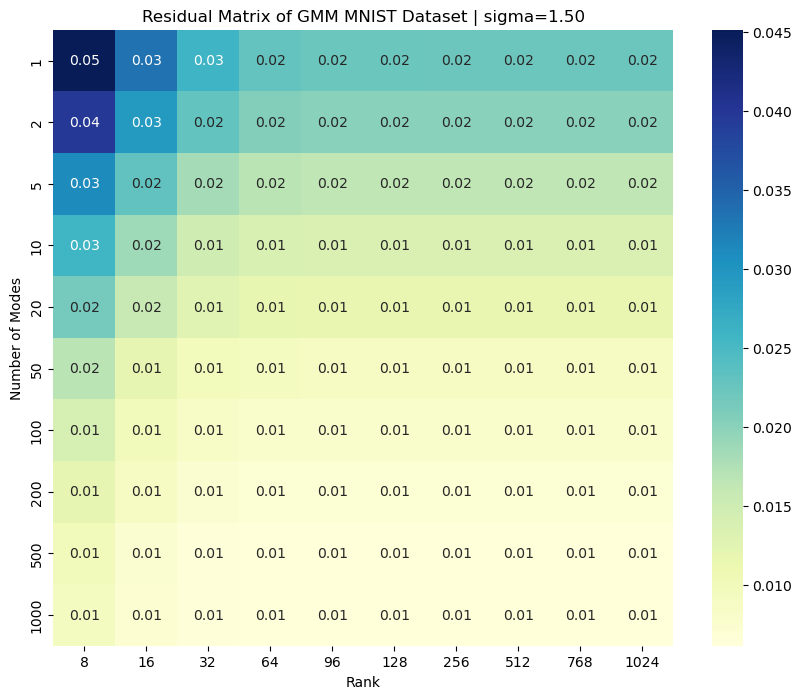

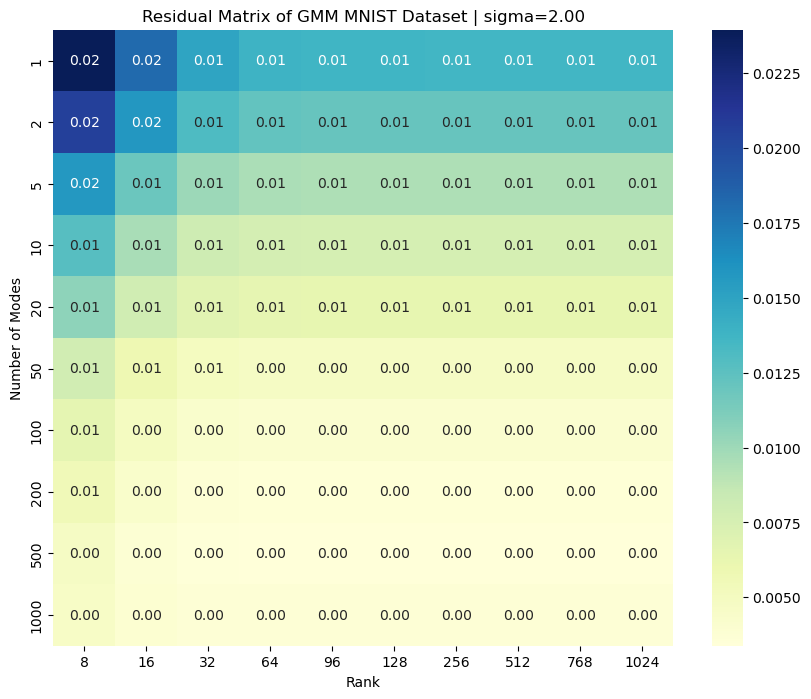

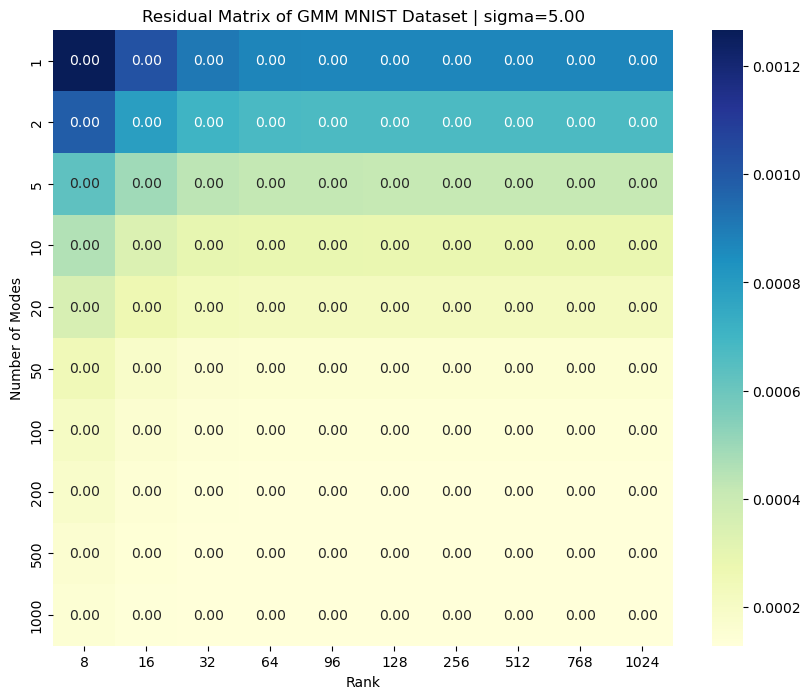

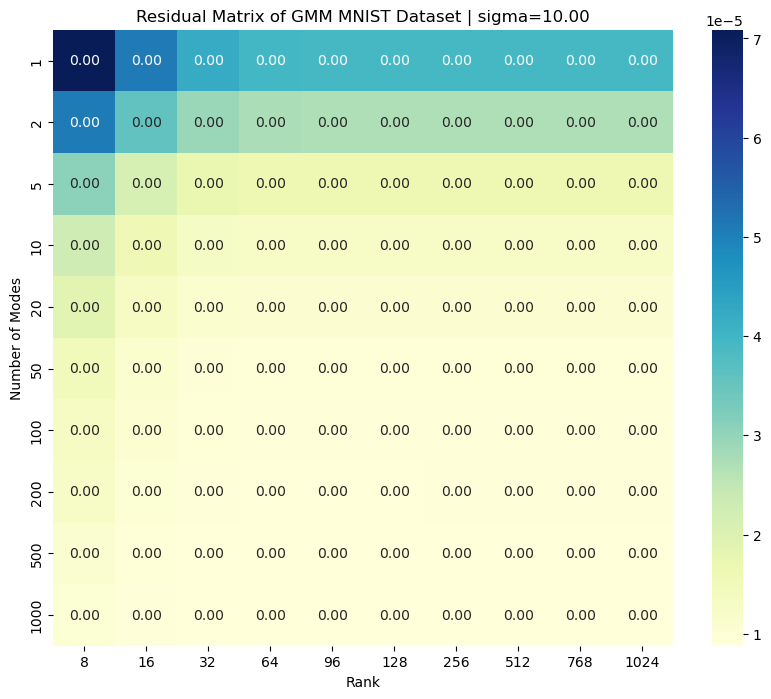

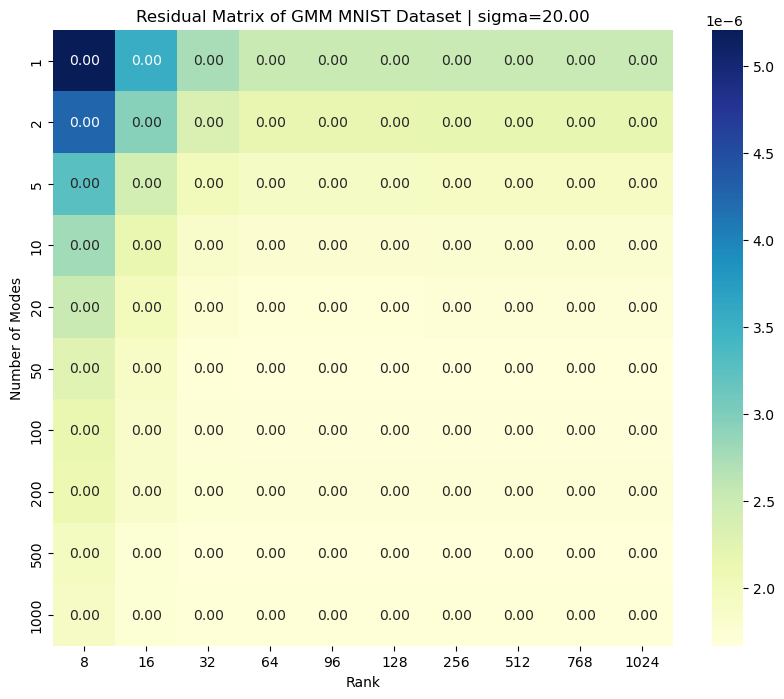

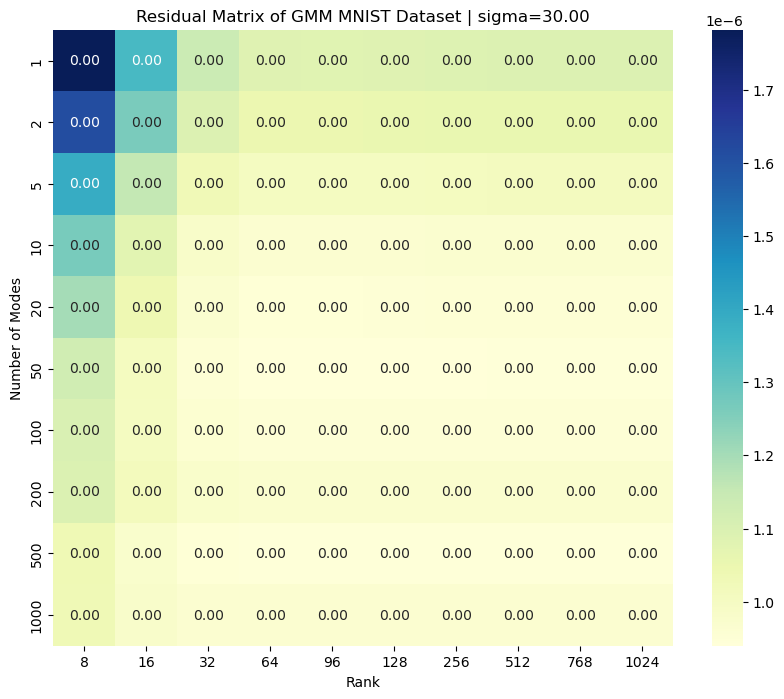

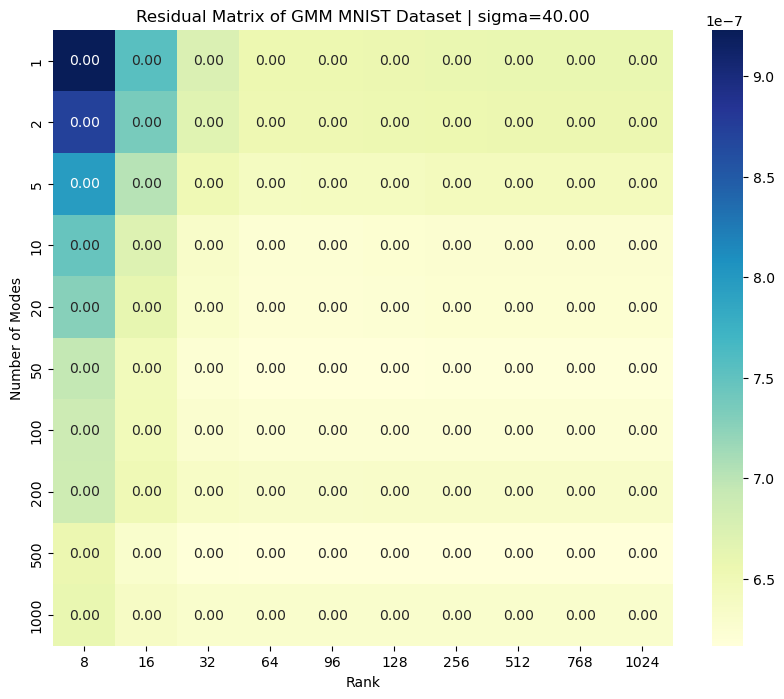

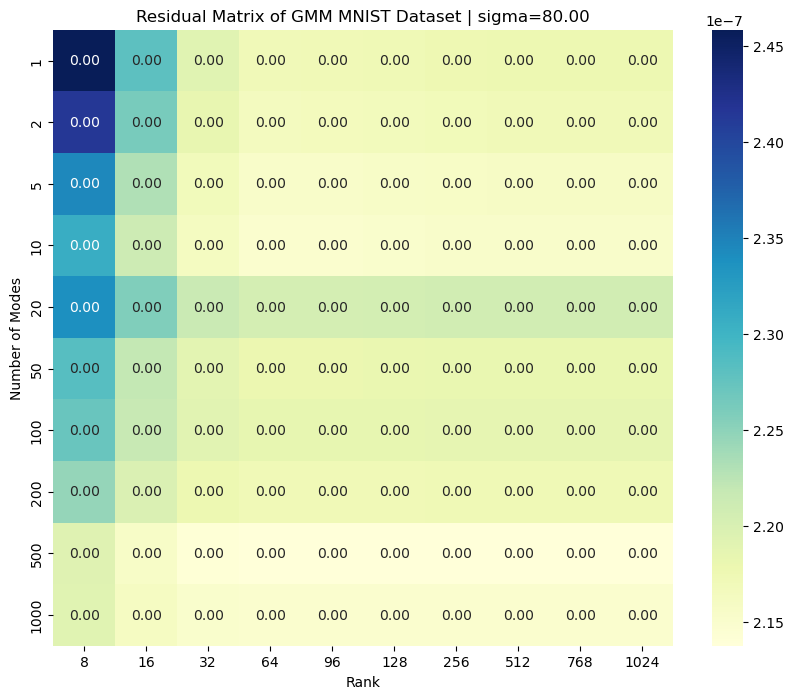

In [51]:
for sigma in df_gmm_rk.sigma.unique():
    # Create a heatmap
    res_mat = []
    for n_clusters in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
        for n_rank in [8, 16, 32, 64, 96, 128, 256, 512, 768, 1024]:
            res = 1 - df_gmm_rk[(df_gmm_rk["name"] == f"gmm_{n_clusters}_mode_{n_rank}_rank") & 
                                (df_gmm_rk.sigma == sigma)]["St_EV"].values
            res_mat.append({"n_clusters": n_clusters, "n_rank": n_rank, "residual": res[0]})
    res_mat = pd.DataFrame(res_mat)
    plt.figure(figsize=(10, 8))
    sns.heatmap(res_mat.pivot_table(index="n_clusters", columns="n_rank", 
                        values="residual", aggfunc="mean"), 
                annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Residual Matrix of GMM MNIST Dataset | sigma=%.2f" % sigma)
    plt.ylabel("Number of Modes")
    plt.xlabel("Rank")
    plt.show()

In [67]:
df_gmm_rk.n_rank.unique()

array([  nan,    8.,   16.,   32.,   64.,   96.,  128.,  256.,  512.,
        768., 1024.])

In [68]:
df_gmm_rk[(df_gmm_rk.n_rank == 1024) & 
        (df_gmm_rk.sigma == 1.0)]

Unnamed: 0   epoch  sigma                     name     St_EV  St_EV_std  St_EV_rev  St_EV_rev_std     Dt_EV  Dt_EV_std  Dt_EV_rev  Dt_EV_rev_std       St_Var  St_Var_std      Dt_Var  Dt_Var_std  n_cluster  n_rank  St_residual  Dt_residual
756         756  999999    1.0     gmm_1_mode_1024_rank  0.961296   0.009548   0.959847       0.009507  0.955774   0.011490   0.953483       0.013183   968.156355   44.390423  845.325940   54.308713        1.0  1024.0     0.038704     0.044226
766         766  999999    1.0     gmm_2_mode_1024_rank  0.964408   0.009742   0.963132       0.009812  0.959295   0.011679   0.957333       0.013107   969.858936   44.698062  847.932861   50.117700        2.0  1024.0     0.035592     0.040705
776         776  999999    1.0     gmm_5_mode_1024_rank  0.969784   0.010491   0.968873       0.010468  0.965417   0.012398   0.963922       0.013745   974.270948   44.539846  853.257889   50.217634        5.0  1024.0     0.030216     0.034583
786         786  999999    1.0    gmm_10_mode_1024_rank  0.974177   0.010390   0.973499       0.010440  0.970393   0.012335   0.969282       0.013437   978.453856   44.666776  858.136136   48.120762       10.0  1024.0     0.025823     0.029607
796         796  999999    1.0    gmm_20_mode_1024_rank  0.977122   0.010113   0.976580       0.010187  0.973764   0.011941   0.972881       0.012848   981.329006   44.691044  860.928122   46.598261       20.0  1024.0     0.022878     0.026236
806         806  999999    1.0    gmm_50_mode_1024_rank  0.981095   0.009518   0.980732       0.009576  0.978307   0.011149   0.977713       0.011783   986.119766   45.107679  865.265257   43.889903       50.0  1024.0     0.018905     0.021693
816         816  999999    1.0   gmm_100_mode_1024_rank  0.982845   0.009343   0.982573       0.009373  0.980312   0.010911   0.979827       0.011466   989.363963   45.031600  867.310899   42.098818      100.0  1024.0     0.017155     0.019688
826         826  999999    1.0   gmm_200_mode_1024_rank  0.984525   0.008499   0.984325       0.008537  0.982216   0.009989   0.981884       0.010363   992.757204   45.322679  870.798390   40.300455      200.0  1024.0     0.015475     0.017784
836         836  999999    1.0   gmm_500_mode_1024_rank  0.986506   0.006973   0.986393       0.007003  0.984506   0.008139   0.984367       0.008226   997.504463   44.796177  875.915621   36.625947      500.0  1024.0     0.013494     0.015494
846         846  999999    1.0  gmm_1000_mode_1024_rank  0.987046   0.006678   0.986998       0.006694  0.985107   0.007833   0.985069       0.007839  1002.265133   44.895909  880.043204   35.341855     1000.0  1024.0     0.012954     0.014893

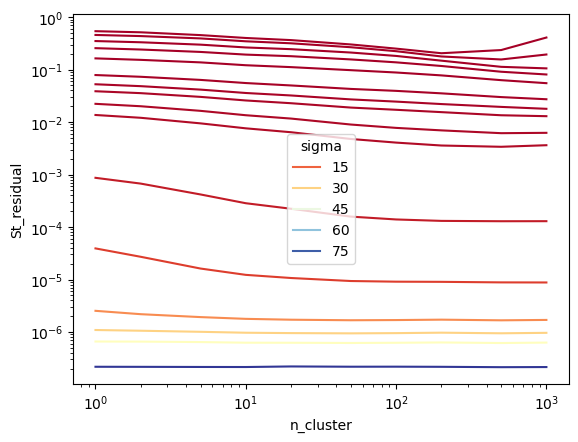

In [74]:
sns.lineplot(data=df_gmm_rk[(df_gmm_rk.n_rank == 1024)],
            x="n_cluster", y="St_residual", hue="sigma", 
            palette="RdYlBu", lw=1.5)
plt.yscale("log")
plt.xscale("log")
plt.show()

### AFHQ 64

In [7]:
df_syn_afhq = pd.read_csv("AFHQ_edm_1k_epoch_gmm_exp_var.csv")

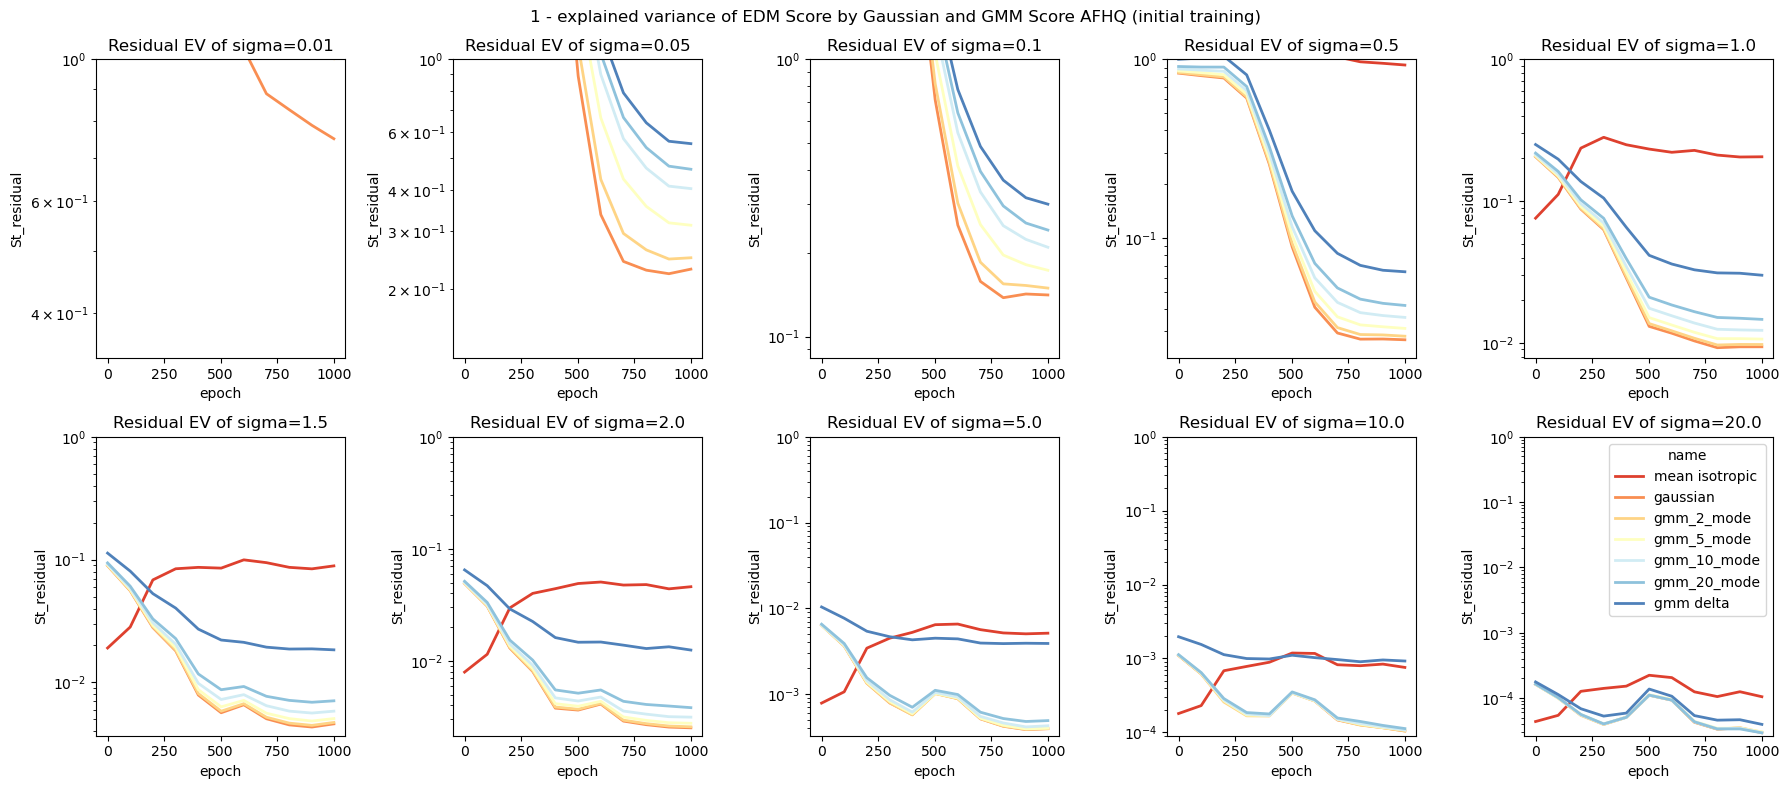

In [10]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_afhq[(df_syn_afhq.sigma == sigma) & (df_syn_afhq.epoch >= 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="St_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", 'gmm_2_mode', 
                'gmm_5_mode', 'gmm_10_mode', 'gmm_20_mode', "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM Score by Gaussian and GMM Score AFHQ (initial training)")
plt.tight_layout()
plt.show()

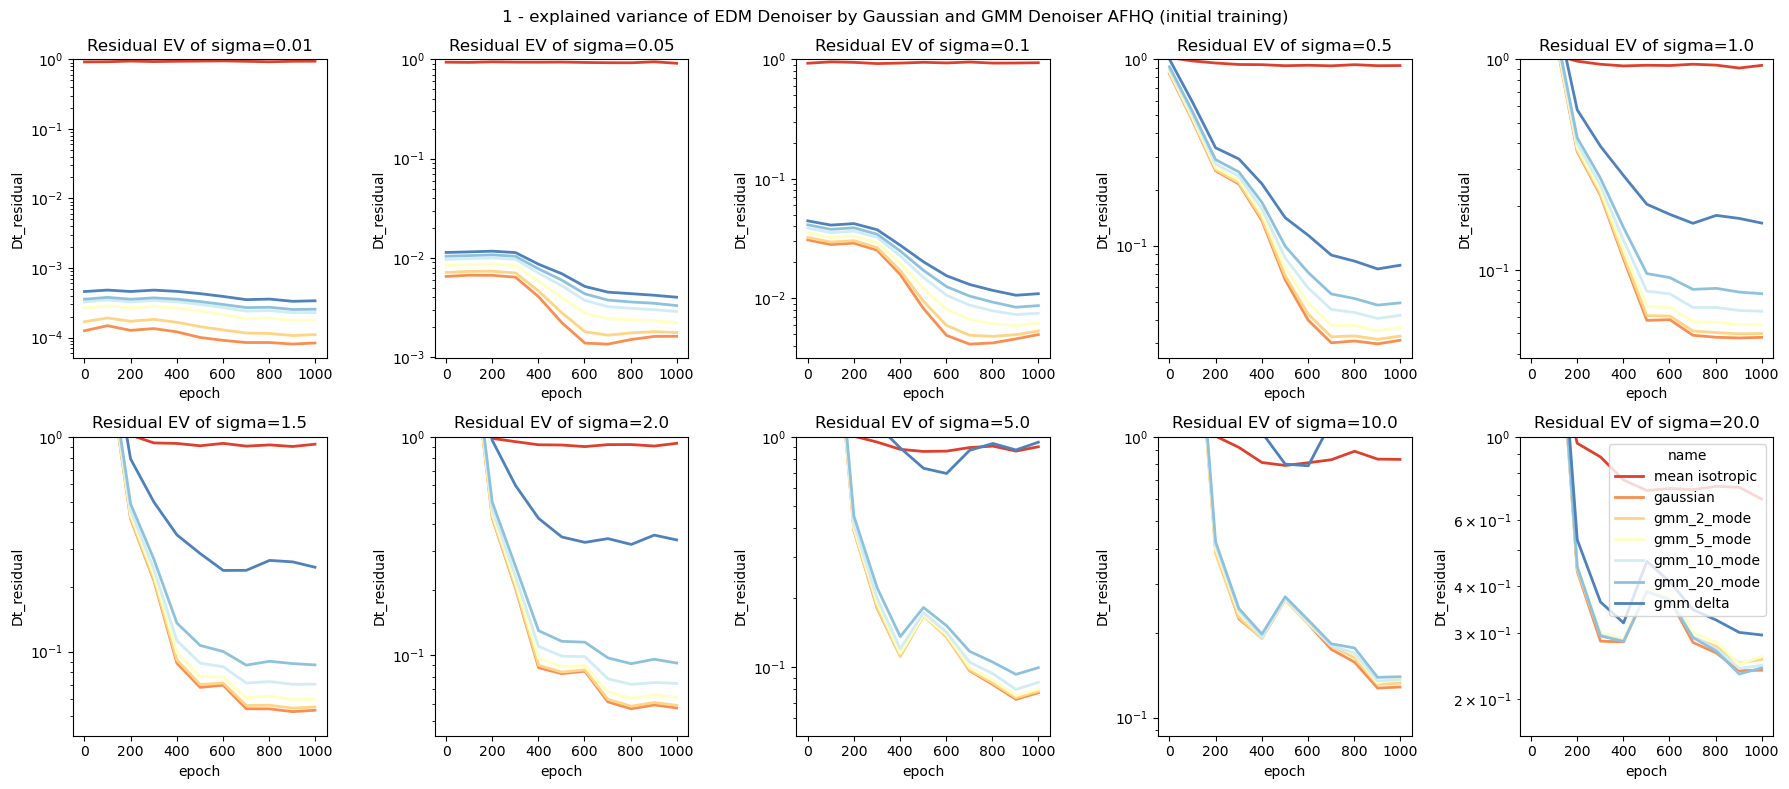

In [11]:
figh, axs = plt.subplots(2, 5, figsize=(18, 8))
axs = axs.flatten()
for i, sigma in enumerate([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, ]):
    df_syn_sigma = df_syn_afhq[(df_syn_afhq.sigma == sigma) & (df_syn_afhq.epoch >= 0)]
    sns.lineplot(data=df_syn_sigma, x="epoch", y="Dt_residual", hue="name", 
                 hue_order=["mean isotropic", "gaussian", 'gmm_2_mode', 
                'gmm_5_mode', 'gmm_10_mode', 'gmm_20_mode', "gmm delta"],
                 palette="RdYlBu", lw=2.0, ax=axs[i])
    axs[i].set_yscale("log")
    axs[i].set_ylim(None, 1)
    axs[i].set_title(f"Residual EV of sigma={sigma}")
    if i < 9:
        axs[i].legend().remove()
plt.suptitle("1 - explained variance of EDM Denoiser by Gaussian and GMM Denoiser AFHQ (initial training)")
plt.tight_layout()
plt.show()